### Mục đích: Xây dựng mô hình dự đoán phim có thành công hay không dựa trên dữ liệu 2 năm gần nhất. Các nhà làm phim sẽ theo dõi và học tập từ những bộ phim thành công để có thể xây dựng phương hướng phát triển cho năm tới.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
file_path = '../../Data/movie_data.csv'
movie_data = pd.read_csv(file_path)
movie_data.head()

,Title,Release time,Age rating,Runtime,Language,IMDb Rating,IMDb Votes,Action,Adventure,Animation,...,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,Win,Nomination,Age rating quantification
0,Goon Squad,2024-01-18,NC-17,83.0,English,6.1,12215.766268,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,5
1,The Phantom Warrior,2024-02-20,R,83.0,English,2.6,532.000000,False,True,False,...,False,True,False,False,False,False,False,0.0,0.0,4
2,Beyond the Lake,2024-01-26,G,98.0,English,6.1,31.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,1
3,Crimes of Fashion: Killer Clutch,2024-03-15,PG,84.0,"English, French",5.8,503.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,2
4,Love on the Danube: Love Song,2024-09-10,G,84.0,English,5.8,175.000000,False,False,False,...,True,False,False,False,False,False,False,0.0,0.0,1


In [4]:
movie_data_cleaned = movie_data.dropna()

# Tạo nhãn "Thành công" dựa trên IMDb Rating (giả định: thành công nếu IMDb > 7.0)
movie_data_cleaned['Success'] = (movie_data_cleaned['IMDb Rating'] > 7.0).astype(int)

features = ['Runtime', 'Age rating quantification', 'IMDb Votes', 
             'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
    'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western' ]

X = movie_data_cleaned[features]
y = movie_data_cleaned['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Xử lý dữ liệu mất cân bằng bằng SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

## 1. Mô hình Random Forest

In [6]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_y_prob = rf_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
rf_auc = auc(rf_fpr, rf_tpr)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Accuracy: 0.8385826771653543
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       431
           1       0.45      0.27      0.34        77

    accuracy                           0.84       508
   macro avg       0.66      0.61      0.62       508
weighted avg       0.81      0.84      0.82       508



## 2. Mô hình Gradient Boosting

In [8]:
# Huấn luyện mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_y_prob = gb_model.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_y_prob)
gb_auc = auc(gb_fpr, gb_tpr)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_y_pred))

Gradient Boosting Accuracy: 0.8543307086614174
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       431
           1       0.54      0.25      0.34        77

    accuracy                           0.85       508
   macro avg       0.71      0.60      0.63       508
weighted avg       0.83      0.85      0.83       508



## 3. Đánh giá mô hình

In [10]:
# Đánh giá mô hình Random Forest
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_y_prob = rf_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_prob)
rf_auc = auc(rf_fpr, rf_tpr)

# Đánh giá mô hình Gradient Boosting
gb_y_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_y_prob = gb_model.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_y_prob)
gb_auc = auc(gb_fpr, gb_tpr)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")
print(f"Random Forest AUC: {rf_auc:.2f}")
print(f"Gradient Boosting AUC: {gb_auc:.2f}")

Random Forest Accuracy: 0.84
Gradient Boosting Accuracy: 0.85
Random Forest AUC: 0.75
Gradient Boosting AUC: 0.75


#### Nhận xét: 
- Gradient Boosting (GB): Accuracy đạt 85.4%, cao hơn Random Forest (RF) với 83.8%.
- AUC (Area Under Curve) của cả hai mô hình đều là 0.75, cho thấy khả năng phân biệt giữa hai lớp của cả hai mô hình là tương đương.

## 3.1. ROC Curve

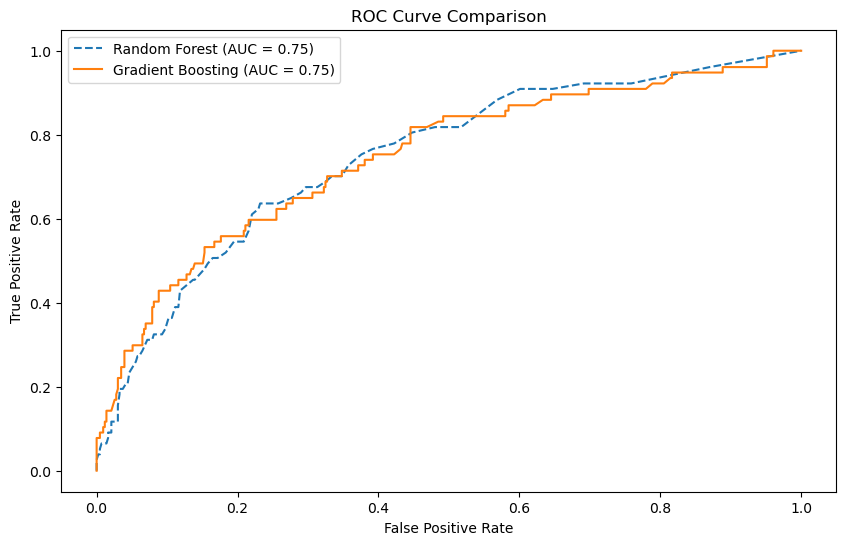

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", linestyle='--')
plt.plot(gb_fpr, gb_tpr, label=f"Gradient Boosting (AUC = {gb_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

## 3.2. Confusion Matrix

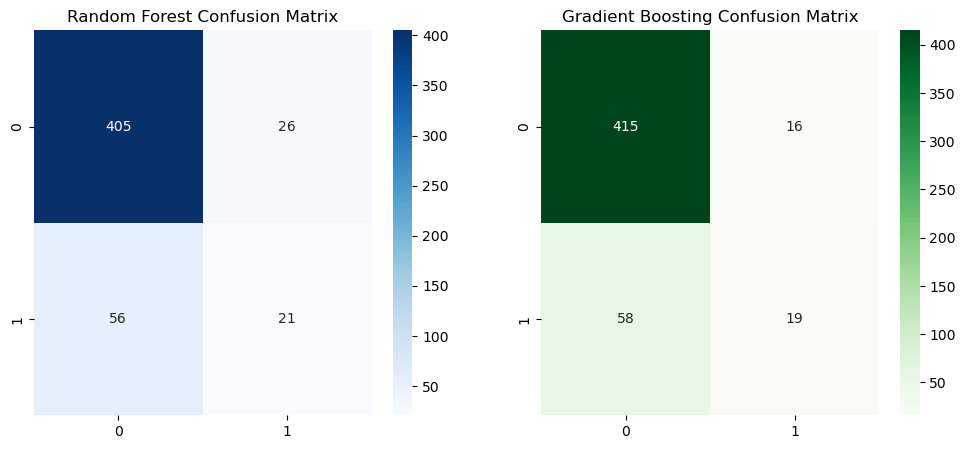

In [15]:
rf_cm = confusion_matrix(y_test, rf_y_pred)
gb_cm = confusion_matrix(y_test, gb_y_pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

#### Nhận xét: 
- Gradient Boosting: Có 415 dự đoán đúng cho lớp 0 và 19 dự đoán đúng cho lớp 1.
- Random Forest: Có 405 dự đoán đúng cho lớp 0 và 21 dự đoán đúng cho lớp 1.
- Gradient Boosting ít nhầm lẫn hơn với lớp 0 (giảm số lượng false positives), nhưng số dự đoán đúng cho lớp 1 lại thấp hơn.

## 4. Kết luận và lựa chọn mô hình

- Gradient Boosting có hiệu suất tổng thể cao hơn, nhưng sự khác biệt không quá lớn so với Random Forest.
- Gradient Boosting phù hợp hơn nếu ưu tiên mô hình có Accuracy cao và khả năng phân biệt lớp tốt hơn.
- Nếu Recall cho lớp 1 là yếu tố quan trọng nhất (ví dụ: dự đoán chính xác các trường hợp đặc biệt), thì Random Forest có thể là một lựa chọn thay thế.

=> Với mục tiêu là xây dựng mô hình dự đoán chính xác các phim thành công, Gradient Boosting là mô hình được khuyến nghị do hiệu suất tổng thể cao hơn và khả năng giảm số lượng dự đoán sai cho lớp 0 (phim không thành công).